In [10]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from scipy.fftpack import fft,ifft
emcee.__version__

'2.2.1'


$p(\vec{x}) \propto \exp \left [ - \frac{1}{2} (\vec{x} -
    \vec{\mu})^\mathrm{T} \, \Sigma ^{-1} \, (\vec{x} - \vec{\mu})
    \right ]$
    
where $\vec{\mu}$ is an N-dimensional vector position of the mean of the density and $\Sigma$ is the square N-by-N covariance matrix(协方差矩阵).

In [2]:
def log_prob(x, mu, cov):
    diff = x - mu
    return -0.5*np.dot(diff, np.linalg.solve(cov,diff))

# np.linalg.solve(a,b)为线性矩阵方程 ax=b 的解x，即 a^{-1} b
# cov 即 \Sigma


ndim = 5

np.random.seed(42)
means = np.random.rand(ndim) # 5*1(随机)向量

cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))  # 5*5矩阵
cov = np.triu(cov)      # 上三角矩阵
cov += cov.T - np.diag(cov.diagonal())  # cov.T=cov转置；cov.diagonal()返回cov对角线；np.diag()生成对角矩阵
cov = np.dot(cov,cov)   # 点乘
print (cov)

[[ 0.50123328 -0.02919697 -0.31413411  0.04476438 -0.10623147]
 [-0.02919697  0.71060761  0.08863136 -0.15006354 -0.1539235 ]
 [-0.31413411  0.08863136  0.29343271 -0.04202359  0.06292544]
 [ 0.04476438 -0.15006354 -0.04202359  0.11739352  0.15256884]
 [-0.10623147 -0.1539235   0.06292544  0.15256884  0.3957519 ]]


In [3]:
nwalkers = 32
p0 = np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[means, cov])

log_prob(p0[0], means, cov)  # 每次结果不同！

-2.5960945890854434

emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn, pool=None, moves=None, args=None, kwargs=None, backend=None, vectorize=False, blobs_dtype=None, a=None, postargs=None, threads=None, live_dangerously=None, runtime_sortingfn=None)

nwalkers：walkers数量

ndim：参数空间维数

log_prob_fn：一个函数，它将参数空间中的向量作为输入，并返回后验概率的自然对数

args（可选）：额外参数列表

……

In [4]:
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()

sampler.run_mcmc(pos, 1000)

(array([[ 1.08428623, -0.2064256 ,  0.26821452,  0.73267956,  0.3814286 ],
        [ 0.87395012,  1.06021082,  0.68161906,  0.81760319, -0.15871141],
        [ 0.58150213,  1.95323087,  0.60685006,  0.1394491 , -0.40799435],
        [ 1.15494628,  0.44725344,  0.10511784,  1.15996356,  0.4466053 ],
        [ 0.99693119,  0.02287299, -0.08087503,  1.04558046,  0.32700807],
        [ 1.59793008,  0.57810811,  0.03640483,  1.06700176,  0.51601505],
        [-0.05588705,  1.39344539,  0.61815869,  0.10071899, -0.49288771],
        [-0.30254496,  0.50260633,  1.21076044,  0.40415115,  1.04350227],
        [-0.39839996,  1.9804566 ,  1.1755425 , -0.01999848, -0.48642751],
        [-0.04722516,  1.27046368,  1.28705525,  0.23209881, -0.28161585],
        [-0.04881551, -0.1893441 ,  1.3310501 ,  0.66530198,  0.65255601],
        [ 0.58411409,  0.62963641,  0.77861493,  0.66570655, -0.54332225],
        [-0.64450766,  1.45746999,  1.38439473,  0.71752559,  0.58657109],
        [ 0.29142618,  0.

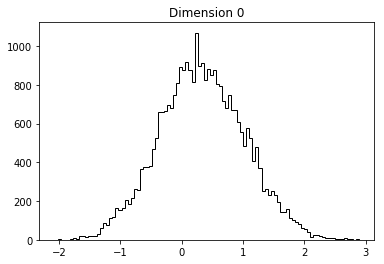

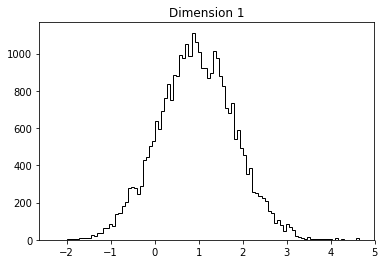

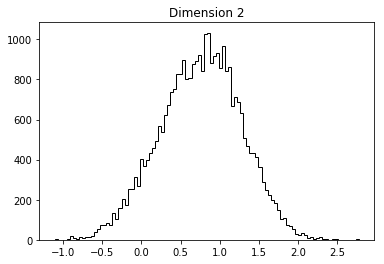

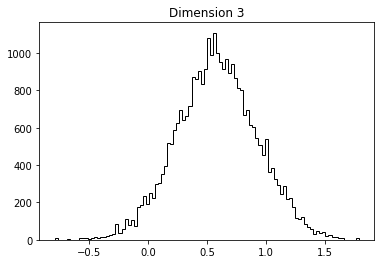

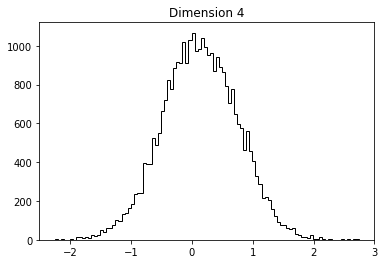

In [5]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

plt.show()

Text(0,0.5,'y')

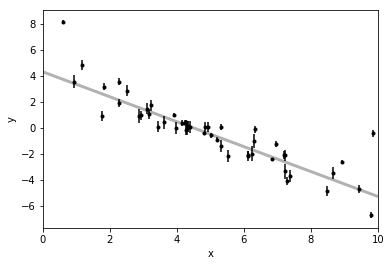

In [6]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true*x0+b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


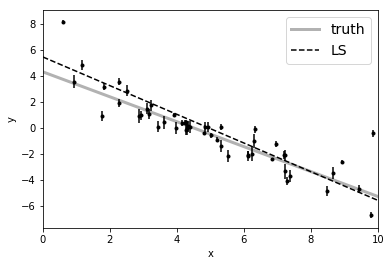

In [7]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true*x0+b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


Text(0,0.5,'y')

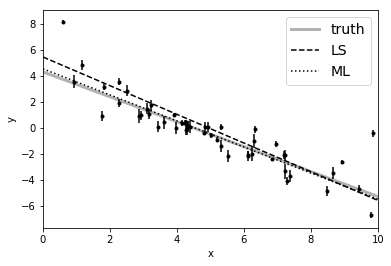

In [8]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1*np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true*x0+b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

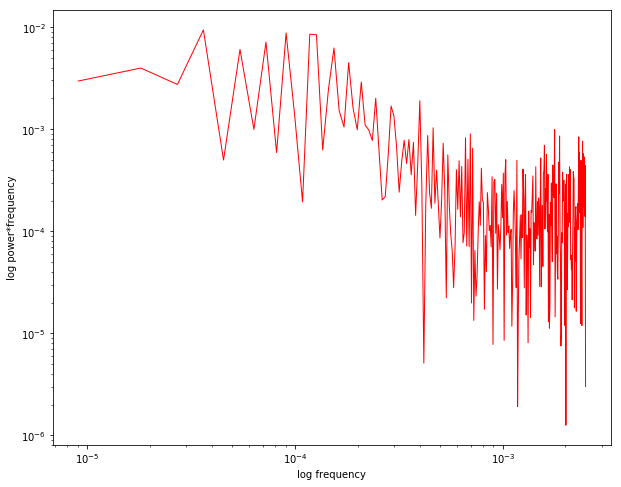

In [14]:
data = pd.read_csv("0.3_10_tb200.csv")  
data['RATE'] = data['RATE'].fillna(data['RATE'].mean())


dt=200
counts_data = data['RATE']
N=len(counts_data)
pnum = np.arange(len(counts_data))
t = [i*dt for i in pnum]


nf = N/2
df = 1/(dt*N)
F_a = np.arange(1,nf+1)
F = [i*df for i in F_a]
F1 = F[0:int(nf)]
mean_x = np.mean(counts_data)
dft = fft(counts_data)
dft1= dft[1:int(nf)+1]
per_data = (abs(dft1)**2)*2*dt/((mean_x**2)*N)
p_times_f_data = np.multiply(np.array(F1),np.array(per_data))

'''
# 数据分bin
F1_binned=databin_20(F1)
per_data_binned = databin_20(per_data)
per_data_b_std = databin_20_std(per_data)
p_times_f_data_b = np.array(F1_binned)+np.array(per_data_binned)
'''


plt.figure(figsize=(10,8))
plt.loglog()
plt.plot(F1,p_times_f_data,color="r",linewidth=1) 
plt.xlabel("log frequency")
plt.ylabel("log power*frequency")
plt.show()

In [20]:
def log_likelihood(theta, x, y):
    A, f_b, alpha_H = theta
    model = ((x**(-alpha_L))/(1+(x/f_b)**(alpha_H-alpha_L)))*A
    return -0.5*np.sum((y/model) + np.log(model))

alpha_L = 1.0

A_0 = 0.005
f_0 = 1.7E-4
alpha_0 = 3.8

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([A_0, f_0, alpha_0])
soln = minimize(nll, initial, args=(F1, per_data))
A_ml, f_ml, alpha_ml = soln.x

print("Maximum likelihood estimates:")
print("A = {0:.3f}".format(A_ml))
print("f_b = {0:.3f}".format(f_ml))
print("alpha_H = {0:.3f}".format(np.exp(alpha_ml)))


plt.plot(x0, m_true*x0+b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y")

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'float'